# **Named Entity Recognition using Transfer Learning**

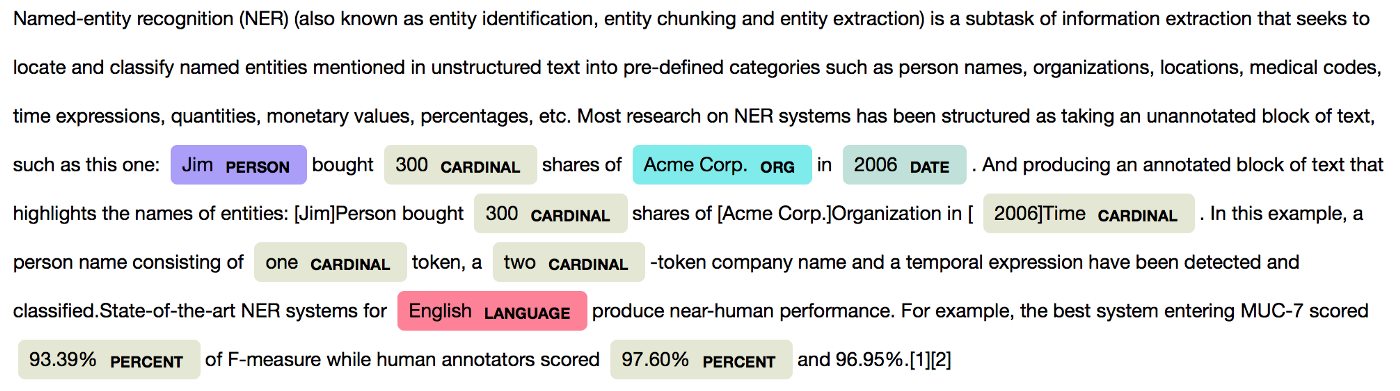

By : [Balamurugan P](https://www.linkedin.com/in/bala-murugan-62073b212/)

# **Overview :**
I have **Fine tuned BERT using HuggingFace transformers** to perform **Named Entity Recognition** on Text data. BERT is a state-of-the-art model with **attention mechanism** as underlying architecture trained with masked-language-modelling and next-sentence-prediction objectives, used for various tasks including Question answering systems, Text Summarization etc... which can also perform token classification tasks such as NER with great performance. 

# **Data :**
**CoNLL-2003 :** The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on four types of named entities: persons, locations, organizations and names of miscellaneous entities that do not belong to the previous three groups. **Link :** https://huggingface.co/datasets/conll2003

In [1]:
# Installing git-lfs and setting up 
# git repo to push model and tokenizer to the hub

!apt-get install git-lfs
!git init
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 2129 kB of archives.
After this operation, 7662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2129 kB]
Fetched 2129 kB in 1s (2433 kB/s) 
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package git-lfs.
(Reading database ... 111661 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Initialized empty Git repository in /kaggle/working/.git/
Updated git hooks.
Git LFS initialized.


In [3]:
pip install datasets seqeval transformers==4.12.5

Note: you may need to restart the kernel to use updated packages.


# **Loading Dataset :**

In [4]:
from datasets import load_dataset

In [5]:
raw_dataset = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [7]:
print(raw_dataset["train"][0]["tokens"])
print(raw_dataset["train"][0]["ner_tags"])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [8]:
dataset_feature = raw_dataset["train"].features
print(dataset_feature)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(num_classes=47, names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], names_file=None, id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(num_classes=23, names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], names_file=None, id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], name

In [9]:
print(dataset_feature["ner_tags"])

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)


In [10]:
ner_labels = dataset_feature["ner_tags"].feature.names
print(ner_labels)    # all NER labels

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


**O** - word doesn’t correspond to any entity.<br>
**B-PER/I-PER** - word corresponds to the beginning of / is inside a person entity.<br>
**B-ORG/I-ORG** - word corresponds to the beginning of / is inside an organization entity.<br>
**B-LOC/I-LOC** - word corresponds to the beginning of / is inside a location entity.<br>
**B-MISC/I-MISC** - word corresponds to the beginning of / is inside a miscellaneous entity.<br>

In [11]:
# labels and respective ids are required to 
# support inference API on huggingFace website

id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: key for key, value in id2label.items()}

In [12]:
model_checkpoint = "bert-base-cased"

# **Importing Tokenizer :**

In [13]:
from transformers import AutoTokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [15]:
sample_input = tokenizer(raw_dataset["train"][0]["tokens"], is_split_into_words=True)

This tokenizer is different from normal tokenizer since it uses **subword tokenization** technique ( Splits single word into multiple tokens ). <br>Hence **word_ids** are used to keep track of the words ( sub-words of same word have same word_id ).

In [16]:
print(sample_input.tokens())
print(sample_input.word_ids())

['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]


In [17]:
print(raw_dataset["train"][0]["ner_tags"])

[3, 0, 7, 0, 0, 0, 7, 0, 0]


After tokenization, There is a mismatch between tokens and labels. 
<br>The following function rectifies it.

In [18]:
def align_labels_and_tokens(word_ids, labels):
    
    """ Aligns tokens and their respective labels
    
    Args:
        word_ids (list): word ids of tokens after subword tokenization.
        labels (list): original labels irrespective of subword tokenization.
        
    Returns:
        updated_labels (list): labels aligned with respective tokens. 
    
    """
    
    updated_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            updated_labels.append(-100 if word_id is None else labels[word_id])   
        elif word_id is None:
            updated_labels.append(-100)
        else:
            label = labels[word_id]
            # B-XXX to I-XXX for subwords (Inner entities)
            if label % 2 == 1:
                label+=1
            updated_labels.append(label)
    return updated_labels


In [19]:
sample_labels = raw_dataset["train"][0]["ner_tags"]
print(sample_labels)
print(align_labels_and_tokens(sample_input.word_ids(), sample_labels))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [20]:
def tokenize_and_align_labels(dataset):
    
    """ Performs tokenization and aligns all tokens and labels
        in the dataset.
    
    Args:
        dataset (DatasetDict): dataset containing tokens and labels.
    
    Returns:
        tokenized_data (dict): contains input_ids, attention_mask, token_type_ids, labels
        
    """
    
    tokenized_data = tokenizer(dataset["tokens"], truncation=True, is_split_into_words=True)
    all_labels = dataset["ner_tags"]
    updated_labels = []
    for i, labels in enumerate(all_labels):
        updated_labels.append(align_labels_and_tokens(tokenized_data.word_ids(i), labels))
    tokenized_data["labels"] = updated_labels
    return tokenized_data


In [21]:
tokenize_and_align_labels(raw_dataset['train'][:5])

{'input_ids': [[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], [101, 1943, 14428, 102], [101, 26660, 13329, 12649, 15928, 1820, 118, 4775, 118, 1659, 102], [101, 1109, 1735, 2827, 1163, 1113, 9170, 1122, 19786, 1114, 1528, 5566, 1106, 11060, 1106, 188, 17315, 1418, 2495, 12913, 1235, 6479, 4959, 2480, 6340, 13991, 3653, 1169, 1129, 12086, 1106, 8892, 119, 102], [101, 1860, 112, 188, 4702, 1106, 1103, 1735, 1913, 112, 188, 27431, 3914, 14651, 163, 7635, 4119, 1163, 1113, 9031, 11060, 1431, 4417, 8892, 3263, 2980, 1121, 2182, 1168, 1190, 2855, 1235, 1103, 3812, 5566, 1108, 27830, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [22]:
tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched = True,
    remove_columns = raw_dataset["train"].column_names
)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [23]:
from transformers import DataCollatorForTokenClassification

In [24]:
# Data collator pads inputs and labels
data_collator = DataCollatorForTokenClassification(
    tokenizer = tokenizer
)

# **Importing model :**

In [25]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(ner_labels),
    id2label = id2label,
    label2id = label2id
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [26]:
# Specifying training arguments

batch_size = 32

args = TrainingArguments(
    model_checkpoint,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01
)

In [27]:
from datasets import load_metric
import numpy as np

In [28]:
# Loading helper function to compute metrics
metric = load_metric("seqeval")

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

In [29]:
def compute_metrics(p):
    
    """ Computes and returns metrics during training.
    
    Args:
        p (tuple): tuple containing predictions, labels as lists.
    
    Returns:
        dict: Dictionary containing precision, recall, f1 score, accuracy. 
    
    """
    
    predictions, labels = p 
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [ner_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [ner_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    metrics = metric.compute(predictions=true_predictions, references=true_labels)
    
    return {
        "precision": metrics["overall_precision"],
        "recall": metrics["overall_recall"],
        "f1": metrics["overall_f1"],
        "accuracy": metrics["overall_accuracy"]
    }


# **Fine-tuning :**

In [30]:
trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
trainer.train()    # Fine-tunes model on downstream task

***** Running training *****
  Num examples = 14041
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1317
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.067705,0.889250,0.921575,0.905124,0.979749
2,0.188300,0.058502,0.920441,0.940424,0.930325,0.984179
3,0.046900,0.054862,0.926170,0.945809,0.935887,0.985445


***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32
Saving model checkpoint to bert-base-cased/checkpoint-500
Configuration saved in bert-base-cased/checkpoint-500/config.json
Model weights saved in bert-base-cased/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-cased/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-cased/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32
Saving model checkpoint to bert-base-cased/checkpoint-1000
Configuration saved in bert-base-cased/checkpoint-1000/config.json
Model weights saved in bert-base-cased/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bert-base-cased/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bert-base-cased/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32


Training completed. Do not forget to share your mode

TrainOutput(global_step=1317, training_loss=0.09688366735714715, metrics={'train_runtime': 319.7947, 'train_samples_per_second': 131.719, 'train_steps_per_second': 4.118, 'total_flos': 1166128434618210.0, 'train_loss': 0.09688366735714715, 'epoch': 3.0})

# **Pushing model to hub :**

In [32]:
from huggingface_hub import notebook_login

notebook_login()    # Authorizes huggingface repo

In [33]:
repo_name = "bert-finetuned-ner"
model.save_pretrained(repo_name, push_to_hub=True)
tokenizer.push_to_hub(repo_name)

/opt/conda/lib/python3.7/site-packages/huggingface_hub/hf_api.py:718: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/balamurugan1603/bert-finetuned-ner into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Download file tf_model.h5:   0%|          | 11.3k/411M [00:00<?, ?B/s]

Download file pytorch_model.bin:   0%|          | 2.83k/411M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/411M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/411M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Configuration saved in bert-finetuned-ner/config.json
Model weights saved in bert-finetuned-ner/pytorch_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 3.38k/411M [00:00<?, ?B/s]

To https://huggingface.co/balamurugan1603/bert-finetuned-ner
   68e6567..997f997  main -> main

Model pushed to the hub in this commit: https://huggingface.co/balamurugan1603/bert-finetuned-ner/commit/997f9973583df34eaa3a05c47640f91e868efd57


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

tokenizer config file saved in bert-finetuned-ner/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# **Evaluating the model :**

In [34]:
import pandas as pd
import matplotlib
from IPython.display import display

matplotlib.style.use('fivethirtyeight') 

In [35]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [ner_labels[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [ner_labels[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)

***** Running Prediction *****
  Num examples = 3453
  Batch size = 32


In [36]:
results_df = pd.DataFrame({"LOC": results["LOC"], "MISC": results["MISC"], "ORG": results["ORG"], "PER": results["PER"]}).drop("number", axis=0)

In [37]:
display(results_df)

,LOC,MISC,ORG,PER
precision,0.908289,0.711392,0.850882,0.951643
recall,0.926259,0.800570,0.900060,0.949289
f1,0.917186,0.753351,0.874781,0.950464


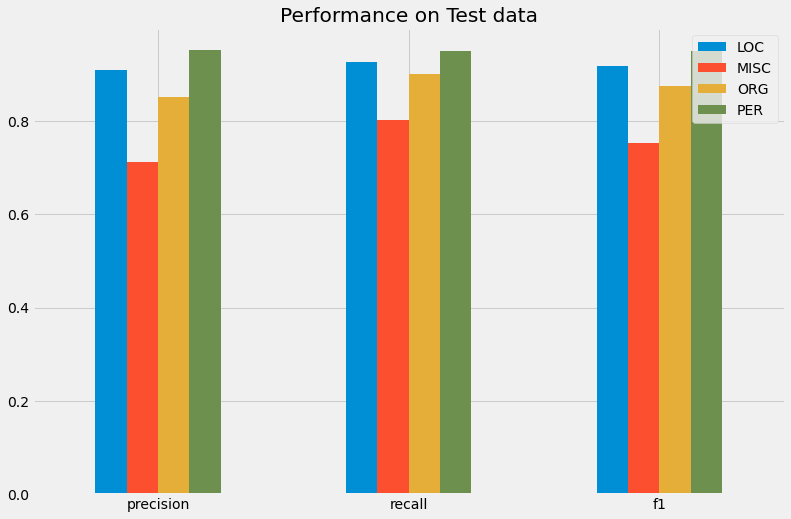

In [38]:
results_df.plot(kind="bar", rot=0, figsize=(12,8))
matplotlib.pyplot.title("Performance on Test data")
matplotlib.pyplot.show()

# **Inference :**

In [39]:
from transformers import pipeline

# Loading the pipeline from hub
# Pipeline handles the preprocessing and post processing steps
model_checkpoint = "balamurugan1603/bert-finetuned-ner"
namedEntityRecogniser = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplhxvqo_k


Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/ee6c77aa9eba1489b57292f0fc4c48fcf124de5672af7169019c0e09833ec733.838709e4b5c0994d4a0dedd847a0f92dc4cd584345db78c3877074d1d1ff0790
creating metadata file for /root/.cache/huggingface/transformers/ee6c77aa9eba1489b57292f0fc4c48fcf124de5672af7169019c0e09833ec733.838709e4b5c0994d4a0dedd847a0f92dc4cd584345db78c3877074d1d1ff0790
loading configuration file https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ee6c77aa9eba1489b57292f0fc4c48fcf124de5672af7169019c0e09833ec733.838709e4b5c0994d4a0dedd847a0f92dc4cd584345db78c3877074d1d1ff0790
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act":

Downloading:   0%|          | 0.00/411M [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b602e39f3d36481bda29a406452f90a08ea956f26e75949fba5e994d50b9d38c.d73f9c3028b2f89cfd5b529bed1481c04fa9e1e204b9b6c065d64979b3e903c0
creating metadata file for /root/.cache/huggingface/transformers/b602e39f3d36481bda29a406452f90a08ea956f26e75949fba5e994d50b9d38c.d73f9c3028b2f89cfd5b529bed1481c04fa9e1e204b9b6c065d64979b3e903c0
loading weights file https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b602e39f3d36481bda29a406452f90a08ea956f26e75949fba5e994d50b9d38c.d73f9c3028b2f89cfd5b529bed1481c04fa9e1e204b9b6c065d64979b3e903c0
All model checkpoint weights were used when initializing BertForTokenClassification.

All the weights of BertForTokenClassification were initialized from the model checkpoint at balamurugan1603/bert-finetuned-ner.
If your task is simila

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f6f57b1dbc0e27159ea1dd9170d46d6cedb0f3cc44bc594d29c62690fe03a0d1.0bbe47aa0e39b09ed05a95f7d42a27299232ce8e9ef28608e8f8a1cb57a74c0a
creating metadata file for /root/.cache/huggingface/transformers/f6f57b1dbc0e27159ea1dd9170d46d6cedb0f3cc44bc594d29c62690fe03a0d1.0bbe47aa0e39b09ed05a95f7d42a27299232ce8e9ef28608e8f8a1cb57a74c0a
https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplvx6664b


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/88ea6be99605930e163dfcdcf7d6a8dac8daf519aeb62b47efc98fd654ce4234.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
creating metadata file for /root/.cache/huggingface/transformers/88ea6be99605930e163dfcdcf7d6a8dac8daf519aeb62b47efc98fd654ce4234.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp737mvqas


Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c3c140d4a2125a4b4ddb68f1af8ef1c13e687424e7044e47cd6985fb34a39b89.d568f51287241d5e78952a910ed52368c509c1901f5da14ee35304b78e23033f
creating metadata file for /root/.cache/huggingface/transformers/c3c140d4a2125a4b4ddb68f1af8ef1c13e687424e7044e47cd6985fb34a39b89.d568f51287241d5e78952a910ed52368c509c1901f5da14ee35304b78e23033f
https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4islj8lc


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/f67d7378bd25d46d6ef4df5197385a6fdbd89566479d172c249cb98bbd03a2b7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/f67d7378bd25d46d6ef4df5197385a6fdbd89566479d172c249cb98bbd03a2b7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/88ea6be99605930e163dfcdcf7d6a8dac8daf519aeb62b47efc98fd654ce4234.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/balamurugan1603/bert-finetuned-ner/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c3c140d4a2125a4b4ddb68f1af8ef1c13e687424e7044e47cd6985fb34a39b89.d568f51287241d5e78952a910ed523

In [41]:
text = "Mark Zuckerberg is one of the founders of Facebook, a company from the United States"

In [43]:
sample_output = namedEntityRecogniser([text])

In [44]:
print(sample_output)

[[{'entity_group': 'PER', 'score': 0.9986679, 'word': 'Mark Zuckerberg', 'start': 0, 'end': 15}, {'entity_group': 'ORG', 'score': 0.98492116, 'word': 'Facebook', 'start': 42, 'end': 50}, {'entity_group': 'LOC', 'score': 0.9936775, 'word': 'United States', 'start': 71, 'end': 84}]]


In [45]:
from spacy import displacy

In [48]:
def visualize(pipeline_output, texts):
    
    """ Visualizes text and their Named entities.
    
    Args:
        pipeline_output (list): Output of the pipeline.
        texts (list): List containing original text.
    
    Returns:
        Nothing
        
    """
    
    for i in range(len(sample_output)):
        entities = []
        for ents in sample_output[i]:
            entities.append({"end": ents["end"], "label": ents["entity_group"], "start": ents["start"]})
        displacy.render({
            "ents": entities,
            "text": texts[i]
        }, style="ent", manual=True)
        

In [49]:
visualize(sample_output, [text])